In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import OneCycleLR

import lightning as L
from lightning import Trainer
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import LearningRateMonitor

from wandb import wandb

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
N = 16

In [3]:
# Load data (parquet)
df = pd.read_parquet("../sho.parquet")
df

,omega,a,s,v0,dv0,v1,dv1,v2,dv2,v3,...,v11,dv11,v12,dv12,v13,dv13,v14,dv14,v15,dv15
0,0.853399,0.858663,-1.597442,0.268484,-0.732782,0.228412,-0.675888,0.191577,-0.618995,0.157979,...,5.719775e-03,-0.106956,0.001253,-0.050063,0.000023,0.006831,2.030368e-03,0.063724,0.007274,0.120617
1,0.124458,0.942548,-0.029341,0.006881,-0.117308,0.005942,-0.109010,0.005072,-0.100713,0.004270,...,3.390003e-04,-0.026038,0.000157,-0.017741,0.000045,-0.009444,6.576447e-07,-0.001147,0.000026,0.007150
2,0.964380,0.945482,-2.425493,0.415693,-0.911803,0.359138,-0.847511,0.306716,-0.783219,0.258428,...,2.092885e-02,-0.204592,0.009842,-0.140300,0.002889,-0.076008,6.862753e-05,-0.011716,0.001382,0.052576
3,0.346069,0.173352,-0.085824,0.001800,-0.059992,0.000682,-0.036921,0.000096,-0.013849,0.000043,...,1.877765e-02,0.193792,0.023515,0.216863,0.028784,0.239934,3.458598e-02,0.263006,0.040920,0.286077
4,0.424457,0.153898,-0.127567,0.002134,-0.065323,0.000685,-0.037026,0.000038,-0.008729,0.000191,...,3.024455e-02,0.245945,0.037604,0.274242,0.045765,0.302540,5.472645e-02,0.330837,0.064489,0.359134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.136966,0.738284,-0.028489,0.005113,-0.101120,0.004231,-0.091989,0.003433,-0.082858,0.002718,...,2.298983e-07,-0.000678,0.000036,0.008453,0.000155,0.017584,3.568512e-04,0.026715,0.000642,0.035846
996,0.111650,0.477203,-0.013652,0.001419,-0.053280,0.001050,-0.045836,0.000737,-0.038393,0.000479,...,4.088923e-04,0.028597,0.000649,0.036040,0.000945,0.043484,1.296777e-03,0.050927,0.001704,0.058370
997,0.422115,0.029268,-0.100413,0.000076,-0.012354,0.000125,0.015787,0.000965,0.043928,0.002597,...,4.416291e-02,0.297197,0.052922,0.325338,0.062474,0.353479,7.281676e-02,0.381620,0.083952,0.409761
998,0.030659,0.452666,-0.000992,0.000096,-0.013878,0.000070,-0.011834,0.000048,-0.009790,0.000030,...,3.702266e-05,0.008605,0.000057,0.010649,0.000081,0.012693,1.085859e-04,0.014737,0.000141,0.016781


In [4]:
omega = df["omega"].values
a     = df["a"].values
s     = df["s"].values

In [5]:
vs = []
dvs = []
for i in range(N):
    vs.append(df[f"v{i}"].values)
    dvs.append(df[f"dv{i}"].values)
vs = np.array(vs).T
dvs = np.array(dvs).T

In [6]:
vs.shape

(1000, 16)

In [7]:
class SHO(Dataset):
    def __init__(self, vs, dvs, omega, a, s):
        self.vs    = vs.astype(np.float32)
        self.dvs   = dvs.astype(np.float32)
        self.omega = omega.astype(np.float32)
        self.a     = a.astype(np.float32)
        self.s     = s.astype(np.float32)

        self.X = np.concatenate([self.vs, self.dvs], axis=1)
        self.y = self.s

    def __len__(self):
        return len(self.vs)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.omega[idx], self.a[idx]

In [8]:
ds = SHO(vs, dvs, omega, a, s)

# Split data
train_size = int(0.8 * len(ds))
test_size = len(ds) - train_size
train_ds, test_ds = random_split(ds, [train_size, test_size])

# Create dataloaders
batch_size = 32
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size)

In [9]:
class MLP(L.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        self.n_in       = hparams["n_in"]
        self.n_out      = hparams["n_out"]
        self.n_hidden   = hparams["n_hidden"]
        self.n_layers   = hparams["n_layers"]
        self.lr         = hparams["lr"]
        self.epochs     = hparams["epochs"]
        self.batchsize  = hparams["batchsize"]

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(self.n_in, self.n_hidden))
        for i in range(self.n_layers):
            self.layers.append(nn.Linear(self.n_hidden, self.n_hidden))
        self.layers.append(nn.Linear(self.n_hidden, self.n_out))
        self.net = nn.Sequential(*self.layers)

    def forward(self, x):
        x = self.net(x)
        return x
    
    def training_step(self, batch, batch_idx):
        x, s, _, _ = batch
        y = self(x)
        loss = F.mse_loss(y, s)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, s, _, _ = batch
        y = self(x)
        loss = F.mse_loss(y, s)
        self.log('val_loss', loss)
        return loss
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        scheduler = OneCycleLR(optimizer, max_lr=self.lr, epochs=self.epochs, steps_per_epoch=len(train_dl) // self.batchsize + 1)
        return {
            'optimizer': optimizer, 
            'lr_scheduler': scheduler, 
            'monitor': 'val_loss',
            'interval': 'epoch',
            'strict': True
        }
    
    def train_dataloader(self):
        return train_dl
    
    def val_dataloader(self):
        return test_dl

In [10]:
hparams = {
    "n_in": 2*N,
    "n_out": 1,
    "n_hidden": 16,
    "n_layers": 3,
    "lr": 1e-4,
    "epochs": 200,
    "batchsize": 32
}

model = MLP(hparams)

In [11]:
# Wandb logger
wandb.init(project="sho")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: axect. Use `wandb login --relogin` to force relogin


In [12]:
# Train
trainer = Trainer(
    max_epochs=hparams["epochs"],
    logger=WandbLogger(),
    callbacks=[LearningRateMonitor(logging_interval='epoch')]
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [13]:
trainer.fit(model)

You are using a CUDA device ('NVIDIA GeForce RTX 3050 4GB Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/xteca/Documents/Project/Research/bounce_simple/.venv/lib/python3.11/site-packages/lightning/pytorch/loggers/wandb.py:389: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/xteca/Documents/Project/Research/bounce_simple/.venv/lib/python3.11/site-packages/lightning/pytorch/core/optimizer.py:375: Found unsupported keys in the optimizer configuration: {'strict', 'interval'}

  | Name   | Type       | Params
---------------------

/home/xteca/Documents/Project/Research/bounce_simple/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/tmp/ipykernel_622673/29790459.py:33: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(y, s)
/home/xteca/Documents/Project/Research/bounce_simple/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/xteca/Documents/Pr

Epoch 0:   0%|          | 0/25 [00:00<?, ?it/s] 

/tmp/ipykernel_622673/29790459.py:26: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(y, s)


Epoch 1:  20%|██        | 5/25 [00:00<00:00, 239.05it/s, v_num=0ghw] 

/tmp/ipykernel_622673/29790459.py:33: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(y, s)


Epoch 199: 100%|██████████| 25/25 [00:00<00:00, 236.69it/s, v_num=0ghw]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 25/25 [00:00<00:00, 225.57it/s, v_num=0ghw]


In [14]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,▁▁▂▂▃▄▅▆▇▇███████▇▇▇▇▆▆▅▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁
train_loss,█▄▃▄▃▁▃▃▃▃▃▂▃▂▂▂▂▂▂▄▂▃▅▂▃▃▄▄▃▂▃▁▂▁▂▃▂▂▄▃
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,██▇▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,199
lr-Adam,0.0
train_loss,0.391
trainer/global_step,4999
val_loss,0.34642


In [20]:
# Test for V(x) = 0.5 * omega^2 * (x - a)^2 for omega = pi/4, a = 0.5
def V(x, omega, a):
    return 0.5 * omega**2 * (x - a)**2

def dV(x, omega, a):
    return omega**2 * (x - a)

omega = np.pi / 4
a = 0.5
xp = 1

x = np.linspace(0, 1, 16)
v = V(x, omega, a)
dv = dV(x, omega, a)

s = -0.5 * (xp + a)**2 * omega * np.tan(omega) + 0.5 * omega * a**2 * (np.tan(omega) - omega)

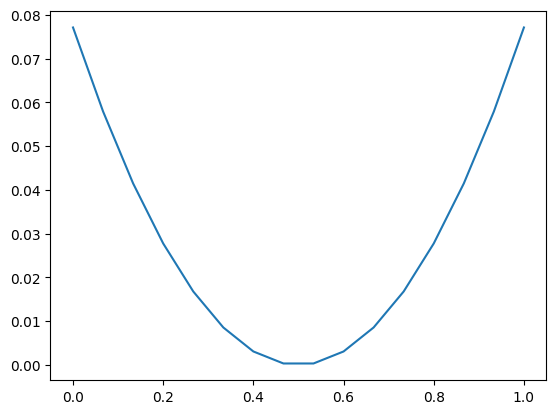

In [21]:
plt.plot(x, v)
plt.show()

In [22]:
s

-0.8625044477809588

In [26]:
# Create test data
vs = v.reshape(1, -1)
dvs = dv.reshape(1, -1)
omega = np.array([omega])
a = np.array([a])
s = np.array([s])

ds_test = SHO(vs, dvs, omega, a, s)
dl_test = DataLoader(ds_test, batch_size=1)

In [27]:
model.eval()
for batch in dl_test:
    x, s, omega, a = batch
    y = model(x)
    print(y.item(), s.item())

-0.5690433979034424 -0.8625044226646423
